# Compute BVA histograms

## Imports

In [1]:
from typing import Dict, List, Tuple

import tqdm

import numpy as np
import pandas as pd

import scipy
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt

import pathlib
import tttrlib

import os

#this is a test

## Custom functions

In [2]:
def update_tttr_dict(
    df: pd.DataFrame,
    data_path: pathlib.Path,
    tttrs: Dict[str, tttrlib.TTTR] = dict()    
):
    for ff, fl in zip(df['First File'], df['Last File']):
        try:
            tttr = tttrs[ff]
        except KeyError:
            fn = str(data_path / ff)
            #tttr = tttrlib.TTTR(fn, 'HT3')
            tttr = tttrlib.TTTR(fn, 'PTU')
            #tttr = tttrlib.TTTR(fn, 'SPC-130')
            tttrs[ff] = tttr    
    return tttrs

In [3]:
def read_analysis(
    paris_path : pathlib.Path,
    paths: List[str] = ['bg4', 'bi4_bur'], #
    file_endings: List[str] = ['bg4', 'bur']  # 
) -> (pd.DataFrame, Dict[str, tttrlib.TTTR]):
    
    info_path = paris_path / 'Info'
    data_path = paris_path.parent

    dfs = list()
    for path, ending in zip(paths, file_endings):
        frames = list()
        for fn in sorted((paris_path / path).glob('*.%s' % ending)):
            df = pd.read_csv(fn, sep='\t')
            df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
            frames.append(df)
        path_df = pd.concat(frames)
        dfs.append(path_df)
    df = pd.concat(dfs, axis=1)
    
#     df = df.dropna()
    
    # Loop through each column and attempt to convert to numeric
    for column in df.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            # Handle exceptions, e.g., if the column contains non-numeric values
            print(f"Could not convert {column} to numeric")
    tttrs = dict()
    update_tttr_dict(df, data_path, tttrs)
    return df, tttrs

In [4]:
def compute_bva_anisotropy_mean_std(
    df: pd.DataFrame, # Target data frame
    # Green parallel
    green_p_channels: List[int] =[0],  
    green_p_micro_time_ranges: List[Tuple[int, int]] = [(0, 12499)], # First & Last Channel Number (Prompt) PQ HydraHarp (TAC Channels)
    
    # Green Perpendicular
    green_s_channels: List[int] = [2],
    green_s_micro_time_ranges: List[Tuple[int, int]] = [(0, 12499)], # First & Last Channel Number (Prompt) PQ HydraHarp (TAC Channels)
    
    #time/photon windown
    minimum_window_length: float = 0.01,  # size of time window within burst
    number_of_photons_per_slice: int = -1
):
    # Iterate through rows using iterrows()
    rs_ratios_mean, rs_ratios_sd = list(), list() # r_scatter
    mt_green_p_mean, mt_green_p_sd = list(), list() # Parallel
    mt_green_s_mean, mt_green_s_sd = list(), list() # Perpendicular
    
    for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
        
        # Select tttr data of burst out of dictionary
        ff, fl = row['First File'], row['Last File']
        tttr = tttrs[ff]
        time_calibration = tttr.header.tag('MeasDesc_GlobalResolution')['value'] # For PTU Files
        #time_calibration = 1/(tttr.header.tag('SyncRate')['value']) # For HT3 files
        #time_calibration = 5.00E-8
        #print(time_calibration) # 50 ns 5E-8
        
        # Select events within burst
        burst_start, burst_stop = int(row['First Photon']), int(row['Last Photon'])
        burst_tttr = tttr[burst_start:burst_stop]
        
        # Either select TWs by the number of photons in a TW or by the number of photons
        if number_of_photons_per_slice < 0:
            
            # Split burst into time windows
            burst_tws = burst_tttr.get_ranges_by_time_window(minimum_window_length, macro_time_calibration=time_calibration)
            burst_tws = burst_tws.reshape((len(burst_tws)//2, 2))
            
            # Create tttr objects of burst TWs
            burst_tws_tttr = [burst_tttr[start: stop] for start, stop in burst_tws]
        else:
            # Split bursts into chunks with a certain number of photons
            chunk_size = number_of_photons_per_slice
            burst_tws_tttr = [burst_tttr[i:i+chunk_size] for i in range(0, len(burst_tttr), chunk_size)]
    
        # Compute for each time window in a burst the proximity ratio
        n_green_p, n_green_s = list(), list()
        mt_green_p, mt_green_s = list(), list()
        for tw_tttr in burst_tws_tttr:            
            # mask all photons that are not Green photons (Parallel)
            mask_green_p = tttrlib.TTTRMask()
            mask_green_p.select_channels(tw_tttr, green_p_channels)
            mask_green_p.select_microtime_ranges(tw_tttr, green_p_micro_time_ranges)
            
            # mask all photons that are not Green photons (Perpendicular)
            mask_green_s = tttrlib.TTTRMask()
            mask_green_s.select_channels(tw_tttr, green_s_channels)
            mask_green_s.select_microtime_ranges(tw_tttr, green_s_micro_time_ranges)
            
            # Assign time window to selector
            mask_green_p.set_tttr(tw_tttr)
            mask_green_s.set_tttr(tw_tttr)
            
            # Get number of green parallel and perpendicular photons in TW
            n_green_p.append(len(mask_green_p.get_indices()))
            n_green_s.append(len(mask_green_s.get_indices()))

            # Get the mean micro time
            mt_green_p.append(tw_tttr[mask_green_p.get_indices()].get_mean_microtime())
            mt_green_s.append(tw_tttr[mask_green_s.get_indices()].get_mean_microtime())

        # Compute mean and sd of intensities rs (Anisotropy)
        tw_n_green_p = np.array(n_green_p)
        tw_n_green_s = np.array(n_green_s)
        
        #Correction Fractors G-factor and background
        G = 1/g
        duration = duration_tw/2 # Calcualtion rom Time windows duration_tw = 5/mean_cr. Divided into 2 because prompt and delay
        tw_B_p = B_p*duration
        tw_B_s = B_s*duration
        
        #Calculation
        tw_rs_ratios = (tw_n_green_p - tw_B_p - G*(tw_n_green_s-tw_B_s))/ (tw_n_green_p - tw_B_p + 2*G*(tw_n_green_s - tw_B_s))
        rs_ratio_mean, rs_ratio_sd = tw_rs_ratios.mean(), tw_rs_ratios.std()
        rs_ratios_mean.append(rs_ratio_mean)
        rs_ratios_sd.append(rs_ratio_sd)

        # Compute mean and sd of microtimes Green Parallel and Perpendicular
        mt_green_p = np.array(mt_green_p)
        mt_green_p_mean.append(mt_green_p.mean())
        mt_green_p_sd.append(mt_green_p.std())

        mt_green_s = np.array(mt_green_s)
        mt_green_s_mean.append(mt_green_s.mean())
        mt_green_p_sd.append(mt_green_s.std())

    rs_ratios_mean = np.array(rs_ratios_mean)
    rs_ratios_sd = np.array(rs_ratios_sd)
    df['Anisotropy Mean'] = rs_ratios_mean #rscatter (background corrected)
    df['Anisotropy Std'] = rs_ratios_sd #rscatter (background corrected)
    
    #df['Microtime Green P Mean'] = mt_green_p_mean
    #df['Microtime Green P Std'] = mt_green_p_sd

    #df['Microtime Green S Mean'] = mt_green_s_mean
    #df['Microtime Green S Std'] = mt_green_s_sd

def compute_static_simulated_species(
    number_of_photons_per_slice_sim: int = 4
) -> Tuple[np.array, np.array]:
    prox_mean = list()
    prox_sd = list()
    n_samples = 10000
    for prox in prox_mean_bins:
        prox_sim_red = np.random.binomial(number_of_photons_per_slice_sim, prox, n_samples)
        prox_sim_green = number_of_photons_per_slice_sim - prox_sim_red
        prox = prox_sim_red / (prox_sim_red + prox_sim_green)
        prox_mean.append(prox.mean())
        prox_sd.append(prox.std())
    return np.array(prox_mean), np.array(prox_sd)

In [5]:
def average_histogram(
    counts: np.ndarray,
    x_bins: np.ndarray,
    y_bins: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Compute the mean and the sd over the bins of a 2D histogram
    """
    mean = list()
    sd = list()
    h = counts
    y = y_bins[1:]
    y2 = y * y
    x = x_bins[1:]
    for i, prox in enumerate(x):
        c = h[i]
        s = np.sum(c)
        m1 = c @ y / s
        m2 = c @ y2 / s
        mean.append(m1)
        v = np.sqrt(m2 - m1*m1) / np.sqrt(s)
        sd.append(v)
    sd = np.array(sd)
    mean = np.array(mean)
    return mean, sd

In [6]:
def filter_burstids(df, bid_path):
    
    # get bid_df to use as a filter on the passed df.
    bid_df = get_bid_df(bid_path)
    
    # Filter df using flphotons.
    result_df = df.merge(bid_df, on=['First Photon', 'Last Photon', 'First File'], how='inner')

#     Debug
#     bid_df.to_csv("bid_df.csv", index=False)
#     result_df.to_csv("result_df.csv", index=False)
    return result_df

In [7]:
# read all of the burst id files in the selected directory and create a dataframe storing 
# their First Photon, Last Photon, and First File values row-wise.

def get_bid_df(bid_path):

    # create dfs list to append each bst file dataframe when reading the directory
    dfs = []
    
    # iterate through the bst files in the specified directory
    for file in sorted((bid_path).glob('*.%s' % 'bst')):
        
        # read each file and create a dataframe
        file_df = pd.read_csv(file, sep ='\t', header=None)
        
        # rename the unnammed columns
        file_df.rename(columns={0: "First Photon", 1: "Last Photon"}, inplace=True)
        
        # get the filename so we can assoc a file to the First File column
        filename = os.path.basename(file).split('.')[0]
        
        # process the filename so that it matches the format in the bur file
        filename = filename.replace("_0", "")
        filename = filename + ".ptu"

        # assign this files First and Last Photon data to the associated file.
        file_df['First File'] = filename
        
        # append the burst file dataframe to a list, will concatenate them all after loop.
        dfs.append(file_df)
        
    # concatenate all the dfs into one 
    flphotons = pd.concat(dfs, axis = 0, ignore_index = True)

    return flphotons

In [8]:
def make_plot(x, y, xlabel, ylabel, nx, ny):

    n_binsx = nx
    n_binsy = ny
    c_map = 'gist_ncar_r'

    # Create a Figure, which doesn't have to be square.
    fig = plt.figure(layout='constrained')
    
    # Create the main axes, leaving 25% of the figure space at the top and on the
    # right to position marginals.
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    
    # The main axes' aspect can be fixed.
    ax.set(aspect="auto")
    ax_histx = ax.inset_axes([0, 1.05, 1.0, 0.25], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    # ax_cbar = ax.inset_axes([1.05, 1.05, 0.25, .25])
    # ax_histy = ax.inset_axes([1.05, .5, 0.25, 1], sharey=ax)
    # ax_cbar = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    # Draw the scatter plot and marginals.
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    if ylabel == "Sg/Sr (prompt)":
        n_binsy = np.geomspace(np.min(y), np.max(y), num=n_binsy)
        plt.yscale("log")

    # the 2d hist plot:
    h = ax.hist2d(x, y, bins = [n_binsx, n_binsy], range=[[xmin, xmax], [ymin, ymax]], 
                  cmap = c_map)
    mappable = h[3]
    fig.colorbar(mappable, ax=ax, location='left')


    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    nx = ax_histx.hist(x, bins=n_binsx, range=[xmin, xmax])
    ny = ax_histy.hist(y, bins=n_binsy, range=[ymin, ymax], orientation='horizontal')
    #nx = ax_histx.hist(x, bins=n_binsx)
    #ny = ax_histy.hist(y, bins=n_binsy, orientation='horizontal')

    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    
    return nx, ny

## Read single molecule analysis & Correction Parameters

In [71]:
# Load PTU Files
file_path = pathlib.Path('/Users/hugosanabria/Dropbox/MFD data 2020/20220314_FoxP1_data_all_NK/20220312_V78C_dimer-DNA_NK/V78C_dimer-DNA_FoxP1_1hr/burstwise_All 0.1771#30')
bid_path = pathlib.Path('/Users/hugosanabria/Dropbox/MFD data 2020/20220314_FoxP1_data_all_NK/20220312_V78C_dimer-DNA_NK/V78C_dimer-DNA_FoxP1_1hr/burstwise_All 0.1771#30/BIDs')


In [72]:
data_path = file_path
df, tttrs = read_analysis(data_path)

Could not convert First File to numeric
Could not convert Last File to numeric


-- WARNING: File /Users/hugosanabria/Dropbox/MFD data 2020/20220314_FoxP1_data_all_NK/20220312_V78C_dimer-DNA_NK/V78C_dimer-DNA_FoxP1_1hr/0 does not exist


In [73]:
# filter the full data set using selected burst ids
df = filter_burstids(df, bid_path)

In [74]:
# Print Column Names
print(df.columns)

Index(['Ng-p-all', 'Ng-s-all', 'Number of Photons (fit window) (green)',
       'Ng-p (fit window)', 'Ng-s (fit window)', '2I*  (green)', 'Tau (green)',
       'gamma (green)', 'r0 (green)', 'rho (green)', 'BIFL scatter? (green)',
       '2I*: P+2S? (green)', 'r Scatter (green)', 'r Experimental (green)',
       'First Photon', 'Last Photon', 'Duration (ms)', 'Mean Macro Time (ms)',
       'Number of Photons', 'Count Rate (KHz)', 'First File', 'Last File',
       'Duration (green) (ms)', 'Mean Macrotime (green) (ms)',
       'Number of Photons (green)', 'Green Count Rate (KHz)'],
      dtype='object')


In [76]:
##Correction g-factor 
g = 1.0 #
B_p = 1.6 # Background kHz Green p
B_s = 1.1 # Background kHz Green s

## Calculate MFD Parameters

# calculate Sg/Sr (prompt)
S_G = df['Green Count Rate (KHz)'] #df['Number of Photons (fit window) (green)']/df['Duration (green) (ms)'] 
S_R = df['S prompt red (kHz) | 0-180']

df['Sg/Sr (prompt)_Burst'] = S_G/S_R

# Plot Various Burtwise MFD

#### Histogram over burst durations, Count Rate, Number of Photons

Display the burst duration and determine the time window for the based on the mode (the most frequent burst duration) the 

Mean Duration 10.1 ms


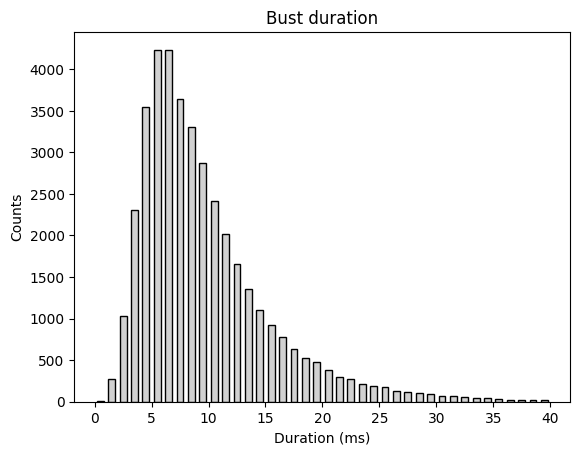

In [77]:
plt.title('Bust duration')
counts_bd, bins_bd, patches_bd =  plt.hist(df['Duration (ms)'], bins=np.linspace(0, 40, 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xlabel('Duration (ms)')
plt.ylabel('Counts')
# Mean Duration
number_of_tws_in_mode = 3
mean_dur = counts_bd @ bins_bd[1:] / np.sum(counts_bd)
minimum_window_length = (mean_dur / 1000.0) / number_of_tws_in_mode
print("Mean Duration {:.1f} ms".format(mean_dur))

Text(0, 0.5, 'Counts')

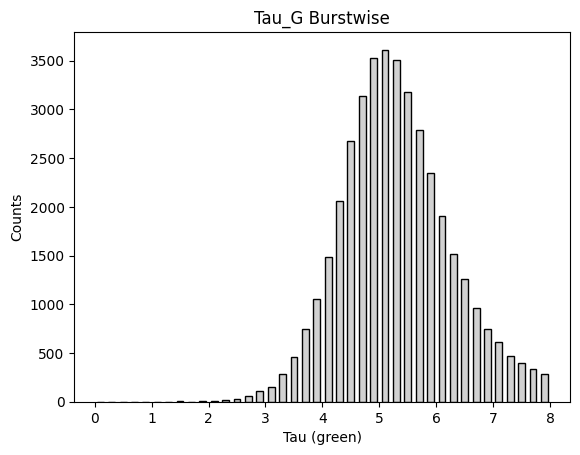

In [78]:
df['Tau (green)'] = df['Tau (green)'].astype(float) ## Convert To Float This columns did not convert co numeric see warning above
plt.title('Tau_G Burstwise')
counts_TG, bins_TG, patches_TG =  plt.hist(df['Tau (green)'], bins=np.linspace(0, 8, 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xlabel('Tau (green)')
plt.ylabel('Counts')

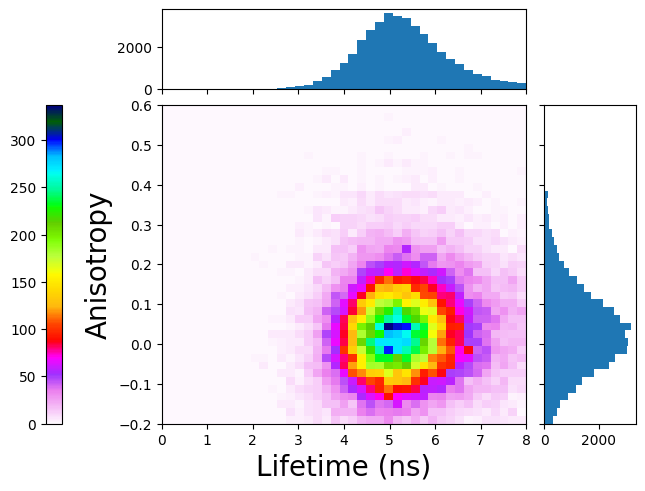

In [79]:
df['r Scatter (green)'] = df['r Scatter (green)'].astype(float) ## Convert To Float This columns did not convert co numeric see warning above


[xmin, xmax], [ymin, ymax] = (0, 8), (-0.2, 0.6)
bins = 41, 41
vmin, vmax = 0.1, 41
nx, ny = make_plot(df['Tau (green)'], df['r Scatter (green)'], 
          'Lifetime (ns)', 'Anisotropy', 41, 41)

plt.title('Sg/Sr (prompt)')
counts_SgSr, bins_SgSr, patches_SgSr =  plt.hist(df['Sg/Sr (prompt)_Burst'], bins=np.logspace(np.log10(0.01), np.log10(185), 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xscale('log')
plt.xlabel('Sg/Sr (prompt)')
plt.ylabel('Events')

Text(0, 0.5, 'Events')

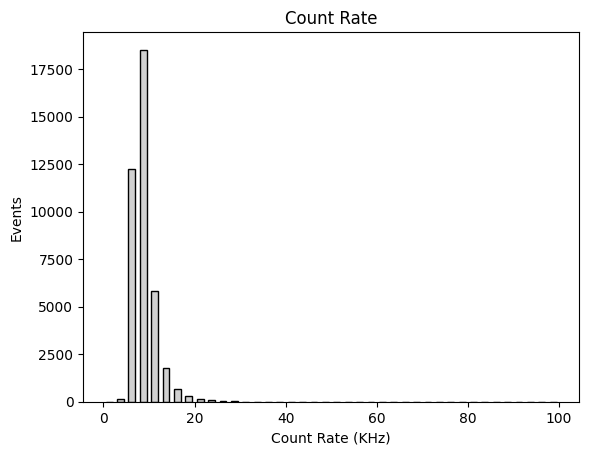

In [80]:
plt.title('Count Rate')
counts_cr, bins_cr, patches_cr =  plt.hist(df['Count Rate (KHz)'], bins=np.linspace(0, 100, 41), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
plt.xlabel('Count Rate (KHz)')
plt.ylabel('Events')

## Calculate mean burst durations, Count Rate, Number of Photons

In [86]:
# Mean Duration
number_of_tws_in_mode = 3
mean_dur = counts_bd @ bins_bd[1:] / np.sum(counts_bd)
minimum_window_length = (mean_dur / 1000.0) / number_of_tws_in_mode
print("Mean Duration {:.1f} ms".format(mean_dur))

# Mean Count Rate
number_of_tws_in_mode = 3
mean_cr = counts_cr @ bins_cr[1:] / np.sum(counts_cr)
print("Mean Count Rate {:.1f} KHz".format(mean_cr))

# Mean Time for # Number of Photons
number_of_photons_per_slice = 30 # Change this every run
duration_tw = number_of_photons_per_slice/mean_cr
print("Duration Time Window {:.3f}".format(duration_tw))

Mean Duration 10.1 ms
Mean Count Rate 10.1 KHz
Duration Time Window 2.961


# Compute mean and variance in bursts

### BVA over fixed number of photons

### Compute mean Anisotropy and variance for simulated static species

In [87]:
print(number_of_photons_per_slice)

30


### Plot 2D BVA

100%|████████████████████████████████████| 39849/39849 [01:53<00:00, 351.65it/s]


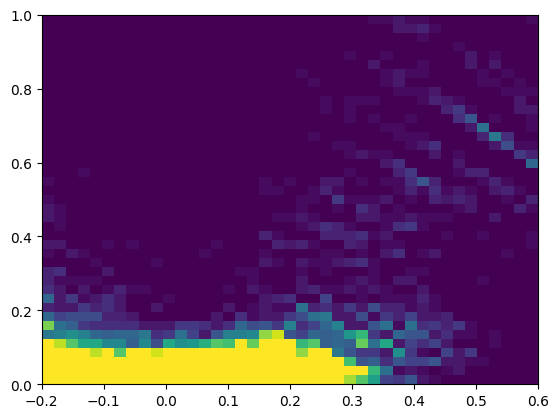

In [88]:
###########################################
###       Compute BVA Anisotropy        ###
###########################################
compute_bva_anisotropy_mean_std(df, number_of_photons_per_slice=number_of_photons_per_slice)
#df_selected = df[df['Anisotropy Std'] > 0.0]
[xmin, xmax], [ymin, ymax] = (-0.2, 0.6), (0, 1)
vmin, vmax = 0.1, 30
counts, rs_mean_bins, rs_sd_bins, _ = plt.hist2d(df['Anisotropy Mean'], df['Anisotropy Std']**2, range=[[xmin, xmax], [ymin, ymax]], bins=(41, 41), vmin=vmin, vmax=vmax)

### Make Final Plot and Export

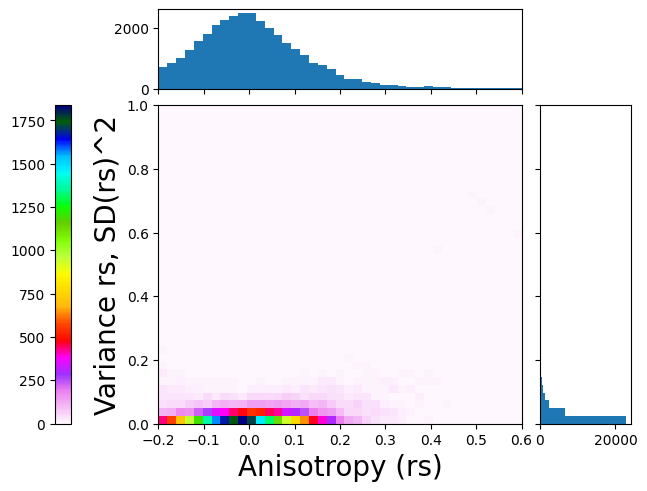

In [89]:
[xmin, xmax], [ymin, ymax] = (-0.2, 0.6), (0, 1)
bins = 41, 41
vmin, vmax = 0.1, 30
x = df['Anisotropy Mean']
y = df['Anisotropy Std']**2 # All variance
#y = df['Anisotropy Std']**2-(df['Anisotropy Mean']*(1-df['Anisotropy Mean'])/number_of_photons_per_slice) # Excess Varaiance S^2 = s^2 - sigma^2, where sigma^2 = E(1-E)/m
nx, ny = make_plot(x, y, 
          'Anisotropy (rs)', 'Variance rs, SD(rs)^2', 41, 41)

In [90]:
## Save files
countsdf = pd.DataFrame(counts)
countsdf.to_csv(str(file_path) + '/counts_' + str(number_of_photons_per_slice) + '_photons' + '.csv')

nxdf = pd.DataFrame(nx)
nxdf.to_csv(str(file_path) + '/nx_' + str(number_of_photons_per_slice) + '_photons' + '.csv')

nydf = pd.DataFrame(ny)
nydf.to_csv(str(file_path) + '/ny_' + str(number_of_photons_per_slice) + '_photons' + '.csv')

#nmean_xdf = pd.DataFrame(x_mean)
#nmean_xdf.to_csv(str(file_path) + '/meanE_' + str(number_of_photons_per_slice) + '_photons' + '.csv')

#nmean_ydf = pd.DataFrame(y_mean)
#nmean_ydf.to_csv(str(file_path) + '/meanvar_' + str(number_of_photons_per_slice) + '_photons' +'.csv')

#nerr_ydf = pd.DataFrame(yerr)
#nerr_ydf.to_csv(str(file_path) + '/errvar_' + str(number_of_photons_per_slice) + '_photons'+ '.csv')